This notebook shows the plotting process for Figure 2, where we present the relationship between the scientist's exploration metrics and performance. Before drawing, we first pre-processed the data in each section. <br>
In the [draw subgraph(a)](#draw-subgraph(a)) section, we calculate the EP and citation per paper for each scientist's entire career and plot the **subgraph (a) of Figure 2** in the main text.<br>
In the [draw subgraph(b)](#draw-subgraph(b)) section, for each paper a scientist publishes, we figure out her past performance and whether this paper is exploratory, and then draw **subgraph (b) of Figure 2**.<br>
In the [draw subgraph(c)](#draw-subgraph(c)) section, we control for the scientists' past performance and compute their past EP and future performance, and then graph **Figure 2(c)**.<br>
In the [draw subgraph(d)-(f)](#draw-subgraph(d)-(f)) section, we use stata to obtain the marginal effects of EP and ED on future performance and draw **Figure 2(d)-(f)**.<br>

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import scipy

import pickle
def save_pkl(path,obj):
    with open(path, 'wb') as f:
        pickle.dump(obj,f)
        
def load_pkl(path):
    with open(path, 'rb') as f:
        return pickle.load(f) 
import math


In [12]:
figsize = (5,5)
fontsize=figsize[0]*3 + 3
font_conf = {'family' : 'Arial', 'weight' : 'normal','size':fontsize}
plt.rc('font', **font_conf)
colors=['steelblue',(0.9019607843137255, 0.0, 0.0, 1.0)]

# load data

In [ ]:
DATA_path='../data/processing_data/'
distance_info = pd.read_pickle(DATA_path+"avg_switch_distance_info.pkl")
author_paper = pd.read_pickle(DATA_path+"author_paper.pkl")

In [ ]:
# authors with more than 10 papers
author_paper = author_paper.loc[author_paper['paperCount']>=10]
all_author = set(author_paper['aid'].unique().tolist())
distance_info = distance_info.loc[distance_info['aid'].isin(all_author)]

# draw subgraph(a)

In [ ]:
#process data
author_paper = author_paper.groupby(['aid']).logCit.mean()
author_paper = author_paper.reset_index()
info = distance_info.merge(author_paper,on=['aid'])

In [ ]:
out = info[['aid','N5_es','N5_es_distance','logCit']]
out.columns = ['aid','EP','ED','logCit']
out.to_csv('../data/fig2/aps_overall.csv',index=False)

In [6]:
aps_data = pd.read_csv('../data/fig2/aps_overall.csv')  

In [7]:
label='EP'
print( f"Correlaiton between {label} and logc5 in aps is {round( float( aps_data.corr()[label] ['logCit'] )  ,5)}" )

Correlaiton between EP and logc5 in aps is -0.10722


In [8]:
## draw 
aps_data['cut'] = (pd.cut(aps_data[label],bins=10,right=True))

data1 = (aps_data.groupby(['cut']).agg({'aid':'count','logCit':'std'}).reset_index())
data1_95 = list(1.96* data1['logCit'] / (data1['aid'].apply(np.sqrt)))
data1 = (aps_data.groupby(['cut']).agg({'logCit':'mean'}).reset_index())
data1_performance = list(data1['logCit'])

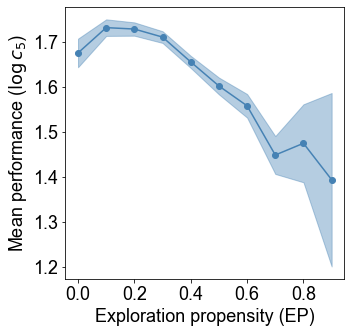

In [9]:
x_labels = np.arange(0,1,.1)
n_step=.1

fig, ax1 = plt.subplots(figsize = figsize)
ax1.plot(x_labels ,data1_performance, '-o',color=colors[0])
ax1.fill_between(  x_labels, data1_performance - np.array(data1_95)     , data1_performance+ np.array(data1_95) ,alpha=0.4,color= colors[0])
font_conf = {'family' : 'Arial', 'weight' : 'normal', 'size': fontsize}
ax1.set_ylabel('Mean performance ($\log c_5$)',fontdict=font_conf) 
ax1.set_xlabel('Exploration propensity (EP)',fontdict=font_conf)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize =fontsize)
plt.yticks(fontsize =fontsize)
ax1.grid(False)
plt.savefig('./draw/figure_2a.png', format="png", bbox_inches="tight")
plt.show()

# draw subgraph(b)

In [ ]:
#process data
result = []
for i,g in tq.tqdm(author_paper.groupby(['aid'])):
    for k in range(1,g.shape[0]):
        result.append([ i,k+1, float(g.head(k).logCit.mean()),float(g.head(k).tail(1).logCit.mean()),  float(g.head(k).tail(5).logCit.mean())   ])

result = pd.DataFrame(result)
result.columns= ['aid','attempt_number','pastmeanlogcitation','pastmeanlogcitation1','pastmeanlogcitation5']

distance_info['lastDate'] = pd.to_datetime(distance_info['lastDate'])
distance_info['thisDate'] = pd.to_datetime(distance_info['thisDate'])
distance_info['firstyear'] = distance_info.aid.map(distance_info.groupby(['aid']).lastDate.min().to_dict())
distance_info["CareerYear"] = (distance_info["thisDate"]-distance_info["firstyear"]).dt.days//365 + 1

result = distance_info[['aid','N5_es','attempt_number','CareerYear']].merge(result,on=['aid','attempt_number'])

t= distance_info[['aid','N5_es','attempt_number','cumMeanCit']]
t.columns=['aid','EP','attempt_number','pastmeanlogcitation']
t.to_csv('../data/fig2/aps_attempts.csv',index=False)

In [10]:
aps_data = pd.read_csv('../data/fig2/aps_attempts.csv')  

In [11]:
left=aps_data['pastmeanlogcitation'].quantile(0)
right=aps_data['pastmeanlogcitation'].quantile(0.995) #0.995
step=(right-left)/(20-1)
x_labels = np.arange(left,right,step)
aps_data['cut'] = (pd.cut(aps_data['pastmeanlogcitation'],bins=list(np.arange(left,right,step)),right=False))

data1 = (aps_data.groupby(['cut']).agg({'aid':'count','EP':'std'}).reset_index())
data1_95 = list(1.96* data1['EP'] / (data1['aid'].apply(np.sqrt)))
data1_count = list(data1['aid'])
data1 = (aps_data.groupby(['cut']).agg({'EP':'mean'}).reset_index())
data1_performance = list(data1['EP'])

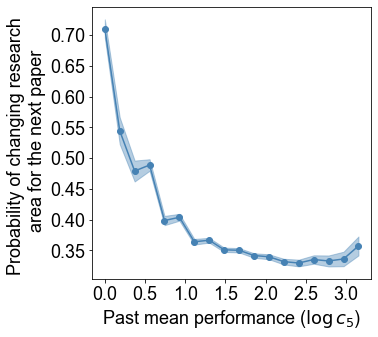

In [12]:
fig, ax1 = plt.subplots(figsize = (5, 5))
ax1.plot(x_labels[:-1] ,data1_performance, '-o',color=colors[0])
ax1.fill_between(  x_labels[:-1], data1_performance - np.array(data1_95)     , data1_performance+ np.array(data1_95) ,alpha=0.4,color= colors[0])
font_conf = {'family' : 'Arial', 'weight' : 'normal', 'size': fontsize}
ax1.set_ylabel('Probability of changing research \n area for the next paper',fontdict=font_conf)
ax1.set_xlabel('Past mean performance ($\log c_5$)',fontdict=font_conf)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize =fontsize)
ax1.grid(False)
plt.savefig('./draw/figure_2b.png', format="png", bbox_inches="tight")
plt.show()

# draw subgraph(c)

In [3]:
def draw_c(label, person_data):
    person_data['cut'] = (pd.cut(person_data[label],bins=10,right=False))

    data1 = (person_data.groupby(['cut']).agg({'aid':'count','post_logCit':'std'}).reset_index())
    data1_95 = list(1.96* data1['post_logCit'] / (data1['aid'].apply(np.sqrt)))
    data1 = (person_data.groupby(['cut']).agg({'post_logCit':'mean'}).reset_index())
    data1_performance = list(data1['post_logCit'])
    x_labels = np.arange(0,1,.1)
    n_step=.1

    fig, ax1 = plt.subplots(figsize = figsize)
    ax1.plot(x_labels ,data1_performance, '-o',color=colors[0])
    ax1.fill_between(  x_labels, data1_performance - np.array(data1_95)     , data1_performance+ np.array(data1_95) ,alpha=0.4,color= colors[0])

    ax1.set_ylabel('Mean future performance ($\log c_5$)',fontdict=font_conf) 
    ax1.set_xlabel('Past exploration propensity (EP)',fontdict=font_conf)
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize =fontsize)
    plt.yticks(fontsize =fontsize)
    plt.ylim(min(data1_performance - np.array(data1_95))-.25, max(data1_performance+ np.array(data1_95))+.25)
    ax1.grid(False)
    plt.savefig('./draw/figure_2c.png', format="png", bbox_inches="tight")
    plt.show()

In [4]:
year_split = pd.read_csv('../data/regression/split_career/cyear_10_author_info.csv')
year_split

,aid,past_paperCount,first_year,first_genre,past_logCit,post_logCit,post_paperCount,post_career,whole_count,past_es,past_es_dis
0,36,4,1988,"[31, 31, 32]",0.447940,1.681995,27,12,31,0.333333,0.678418
1,37,19,2004,"[61, 71, 71, 73]",2.278066,3.204861,5,1,24,0.722222,0.629123
2,40,2,1989,[25],1.647918,2.303875,15,5,17,0.000000,0.727827
3,44,19,2005,"[71, 75, 75]",2.360006,1.609438,1,0,20,0.388889,0.567453
4,45,4,1995,"[52, 52]",1.657010,1.563793,17,8,21,0.666667,0.793923
...,...,...,...,...,...,...,...,...,...,...,...
19407,2139982,2,2000,[4],1.666102,1.188918,14,4,16,0.000000,0.128030
19408,2144117,12,2002,"[11, 11, 11]",1.269248,0.693147,2,1,14,0.181818,0.236967
19409,2144212,10,1998,"[14, 12, 13, 14]",1.908383,1.926316,4,2,14,0.111111,0.304912
19410,2156199,7,1996,"[14, 96, 97]",1.831082,1.521449,3,5,10,0.666667,0.562859


In [6]:
#get different quantiles of the authors' performance  
quantiles = [np.percentile(year_split.past_logCit, 10*i) for i in range(0,11)]
quantiles

[0.0,
 0.9098727112124514,
 1.1454435142116517,
 1.3104558331617453,
 1.4575965149133516,
 1.5968437595177367,
 1.7421765116752093,
 1.8994733056626676,
 2.08718261854466,
 2.355262136972534,
 4.264155320098481]

In [8]:
quantiles = [np.percentile(year_split.past_logCit, 10*i) for i in range(0,11)]
quantiles
group = []
for i in range(10):
    group.append(year_split[(year_split.past_logCit>=quantiles[i])&(year_split.past_logCit<quantiles[i+1])])

In [9]:
group[6][['aid','past_logCit','past_es','post_logCit']].reset_index(drop=True).to_csv('../data/fig2/pastes_futurecit.csv',index=False)

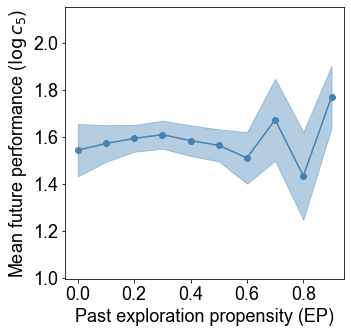

In [13]:
draw_c('past_es', pd.read_csv('../data/fig2/pastes_futurecit.csv'))

# draw subgraph(d)-(f)

In [ ]:
# Run the following code with stata to obtain the corresponding margin effect
'''
cd ../data/regression/split_career/
//year
clear
insheet using stata_10_year.csv

cd ../../fig2

reg post_logcit past_logcit past_es past_papercount i.first_year genre_* if (past_papercount>=5 & post_papercount>=3)
//margin
margins, at( past_es=(0(0.05)1))  post
//out
parmest, label format(p %8.2f) stars(0.1 0.05 0.01) ///
list(parm label estimate min95 max95 p stars, clean noobs)
parmest, saving("10yearonlyep.dta", replace) format(parm %20s ///
estimate %8.3f std %8.3f t %8.3f min95 %8.3f max95 %8.3f p %8.2f)


reg post_logcit past_logcit past_es past_es_dis past_papercount i.first_year genre_* if (past_papercount>=5 & post_papercount>=3)
margins, at( past_es_dis=(0(0.05)1)) post 

parmest, label format(p %8.2f) stars(0.1 0.05 0.01) ///
list(parm label estimate min95 max95 p stars, clean noobs)
parmest, saving("10yeared.dta", replace) format(parm %20s ///
estimate %8.3f std %8.3f t %8.3f min95 %8.3f max95 %8.3f p %8.2f)


reg post_logcit past_logcit past_es past_es_dis past_papercount i.first_year genre_* if (past_papercount>=5 & post_papercount>=3)
margins, at( past_es=(0(0.05)1))  post
parmest, label format(p %8.2f) stars(0.1 0.05 0.01) ///
list(parm label estimate min95 max95 p stars, clean noobs)
parmest, saving("10yearep.dta", replace) format(parm %20s ///
estimate %8.3f std %8.3f t %8.3f min95 %8.3f max95 %8.3f p %8.2f)

'''

In [27]:
def draw_margins(result,label,text,save_path):
    if(label=='EP'):
        color = colors[0]
    if(label=='ED'):
        color= colors[0]
    
    x_label=list(np.arange(0,1.05,.05))
    fig,ax1 = plt.subplots(figsize = figsize)
    ax1.plot(x_label , result['estimate'] ,label =text ,  marker ='o',color=color )
    ax1.fill_between(  x_label, list(result['min95'])    , list(result['max95']),alpha=0.4,color= color)

    ax1.set_ylabel('Predictive margins',fontdict=font_conf)
    
    if(label=='EP'):
        ax1.set_xlabel('Past exploration propensity (EP)',fontdict=font_conf)
        plt.text(0.05,0.8,text,fontsize=fontsize, transform = ax1.transAxes)
    if(label=='ED'):
        ax1.set_xlabel('Past exploration distance (ED)',fontdict=font_conf)
        plt.text(0.25,0.8,text,fontsize=fontsize, transform = ax1.transAxes)
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize =fontsize)
    ax1.grid(False)
    
    plt.savefig(save_path, format="png", bbox_inches="tight")
    plt.show()

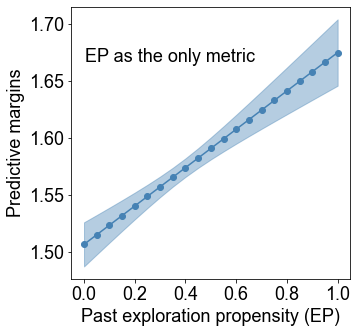

In [28]:
result = pd.read_stata('../data/fig2/10yearonlyep.dta')
draw_margins(result,'EP','EP as the only metric','./draw/figure_2d.png')

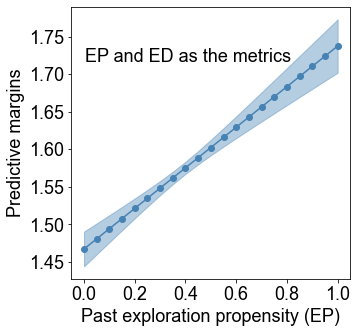

In [29]:
result = pd.read_stata('../data/fig2/10yearep.dta')
draw_margins(result,'EP','EP and ED as the metrics','./draw/figure_2e.png')

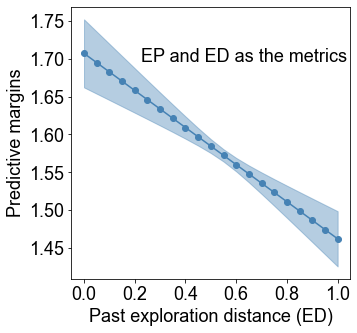

In [30]:
result = pd.read_stata('../data/fig2/10yeared.dta')
draw_margins(result,'ED','EP and ED as the metrics','./draw/figure_2f.png')